In [1]:
import torch
import scipy as sc
import numpy as np
from PIL import Image
import os
import re
import torch.nn.functional as F
import cv2
import numpy as np
import time
from scipy.io import loadmat, savemat
import torch.nn as nn
from tensorflow.keras.optimizers import Adam
from torch.autograd import Variable
from torchvision.models import resnet
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [ ]:
folder_path = os.path.dirname(os.path.dirname(os.getcwd()))
folder_path

In [2]:
torch.cuda.empty_cache()

In [3]:
transform = transforms.ToTensor()

In [4]:
device = torch.device("cuda:0")
torch.set_default_device(device)

#torch.cuda.set_per_process_memory_fraction(0.5, device=device)

print(torch.cuda.get_device_properties(device).multi_processor_count)
torch.cuda.memory_allocated(device=torch.device("cuda"))
torch.cuda.memory_summary(device=torch.device("cuda"), abbreviated=False)

36


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |\n|       from large pool |      0 B   |      0 B   |

In [5]:
#label = loadmat(r''+folder_path+r'\Data\Test_gt\001.mat').get('mask')
image = cv2.imread(r''+folder_path+r'\NewData\Veins\Veins\train\Original\1_A.png')
label = cv2.imread(r''+folder_path+r'\NewData\Veins\Veins\train\Ground truth\1_A.png')

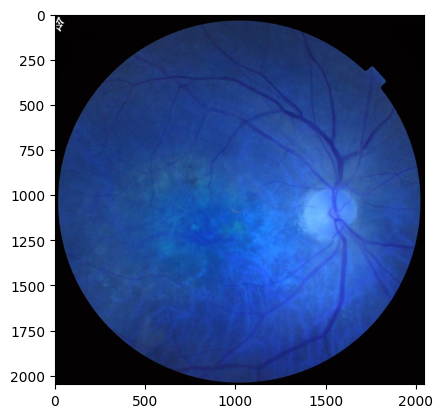

In [6]:
plt.imshow(image)

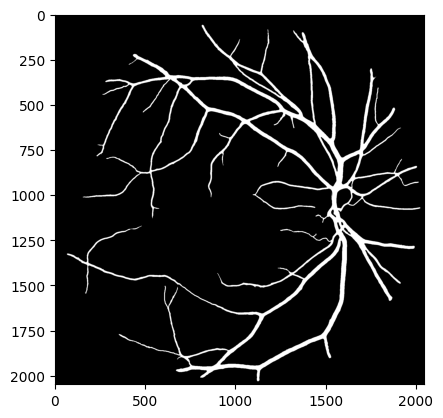

In [7]:
plt.imshow(label)

In [8]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(self.image_paths))
        
    def __getitem__(self, idx):
        image_path = os.listdir(self.image_paths)[idx]
        label_path = os.listdir(self.label_paths)[idx]
        
        image = cv2.imread(self.image_paths + "\/" + image_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        label = cv2.imread(self.label_paths + "\/" +label_path)
        label = label[:,:,0]
        # label[label == 1] = 0
        # label[label == 2] = 255

        if self.transform:
            image = Image.fromarray(image) 
            image = self.transform(image)#.to(device)
            #image = image/255
    
            label = Image.fromarray(label)
            label = self.transform(label)
        
        return image, label

In [9]:
data_transform = transforms.Compose([
    transforms.Resize((512, 512), antialias=True),
    transforms.ToTensor(),
])

In [10]:
train_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\Veins\Veins\train\Original', r''+folder_path+r'\NewData\Veins\Veins\train\Ground truth', data_transform)
valid_dataset = CustomSegmentationDataset(r''+folder_path+r'\NewData\Veins\Veins\valid\Original', r''+folder_path+r'\NewData\Veins\Veins\valid\Ground truth', data_transform)

In [11]:
batchSize = 64
train_data = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)
valid_data = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=True, generator=torch.Generator(device='cuda'), num_workers=0, 
    pin_memory=True)

In [12]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=bias)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size, 1, padding, groups=groups, bias=bias)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.downsample = None
        if stride > 1:
            self.downsample = nn.Sequential(nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                            nn.BatchNorm2d(out_planes),)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        out = self.dropout(out)
        return out

In [13]:
class Encoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, groups=1, bias=False, dropout_rate = 0):
        super(Encoder, self).__init__()
        self.block1 = BasicBlock(in_planes, out_planes, kernel_size, stride, padding, groups, bias, dropout_rate)
        self.block2 = BasicBlock(out_planes, out_planes, kernel_size, 1, padding, groups, bias, dropout_rate)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        return x


In [14]:
class Decoder(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=False):
        # TODO bias=True
        super(Decoder, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_planes, in_planes//4, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.tp_conv = nn.Sequential(nn.ConvTranspose2d(in_planes//4, in_planes//4, kernel_size, stride, padding, output_padding, bias=bias),
                                nn.BatchNorm2d(in_planes//4),
                                nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(in_planes//4, out_planes, 1, 1, 0, bias=bias),
                                nn.BatchNorm2d(out_planes),
                                nn.ReLU(inplace=True),)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tp_conv(x)
        x = self.conv2(x)

        return x

In [15]:
class LinkNetBase(nn.Module):
    """
    Generate model architecture
    """

    def __init__(self, n_classes=1, num_channels = 1):
        """
        Model initialization
        :param x_n: number of input neurons
        :type x_n: int
        """
        super(LinkNetBase, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.encoder1 = Encoder(64, 64, 3, 1, 1)
        self.encoder2 = Encoder(64, 128, 3, 2, 1)
        self.encoder3 = Encoder(128, 256, 3, 2, 1)
        self.encoder4 = Encoder(256, 512, 3, 2, 1)
        
        self.decoder1 = Decoder(64, 64, 3, 1, 1, 0)
        self.decoder2 = Decoder(128, 64, 3, 2, 1, 1)
        self.decoder3 = Decoder(256, 128, 3, 2, 1, 1)
        self.decoder4 = Decoder(512, 256, 3, 2, 1, 1)

        # Classifier
        self.tp_conv1 = nn.Sequential(nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(inplace=True),)
        self.conv2 = nn.Sequential(nn.Conv2d(32, 32, 3, 1, 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace=True),)
        self.tp_conv2 = nn.ConvTranspose2d(32, n_classes, 2, 2, 0)
        
        self.conv3 =  nn.Sequential(nn.Conv2d(16, 16, 2, 2, 0),
                                nn.BatchNorm2d(16),
                                nn.ReLU(inplace=True),)
        self.tp_conv3 = nn.ConvTranspose2d(16, n_classes, 2, 2, 0)

        
        self.lsm = nn.LogSoftmax(dim=1) #Sigmoid/SoftMax
        self.sigm = nn.Sigmoid()
        self.sftmax = nn.Softmax(dim=1)
            
    def forward(self, x):
        # Initial block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Encoder blocks
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        
        # Decoder blocks
        d4 = e3 + self.decoder4(e4)
        d3 = e2 + self.decoder3(d4)
        d2 = e1 + self.decoder2(d3)
        d1 = x + self.decoder1(d2)

        # Classifier
        y = self.tp_conv1(d1)
        y = self.conv2(y)
        y = self.tp_conv2(y)
        y = self.sigm(y)
        
        return y

In [16]:
num_epochs = 50   #25 epoch good
best_val_loss = float('inf')
early_stop_patience = 5
learning_rate = 0.0001
weight_decay = 0.001

In [17]:
model = LinkNetBase()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 
criterion = torch.nn.BCELoss()
print(model)

LinkNetBase(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Encoder(
    (block1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0, inplace=False)
    )
    (block2): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
train_loss_list = []
valid_loss_list = [] 
total_accuracy = 0.0
total_iou = 0.0
total_samples = 0
success_epoch = 0
clip_value = 1

for epoch in range(num_epochs): 
    start_time = time.time()
    print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ')
    
    success_epoch+=1
    train_loss = 0
    valid_loss = 0
    #Iterating over the training dataset in batches 
    model.train() 
    for images, labels in train_data: 
        #Extracting images and target labels for the batch being iterated 
        images = images.to(device) 
        labels= labels.to(device) 
        #Calculating the model output and the cross entropy loss 
        outputs = model.forward(images) 
        
        loss = criterion(outputs, labels) 
        #Updating weights according to calculated loss 
        optimizer.zero_grad() 
        loss.backward() 
        #torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step() 
        
        # l1_loss = 0
        # l2_loss = 0
        # for name, param in model.named_parameters():
        #     if 'weight' in name:
        #         l1_loss += torch.sum(torch.abs(param))
        #         l2_loss += torch.sum(torch.pow(param, 2))
        # loss += 1e-5 * (l1_loss + l2_loss)
        
        train_loss += loss.item() 
        
        #outputs = (outputs > 0.5).float()
        
    #     batch_iou = get_IoU(outputs, labels)
    #     total_iou += batch_iou

    #     batch_accuracy = get_accuracy(outputs, labels)
    #     total_accuracy += batch_accuracy
        
    #     total_samples += images.size(0)
            
    # average_iou_train = total_iou / total_samples
    # average_accuracy_train = total_accuracy / total_samples
    
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_data):
            images = images.to(device) 
            labels = labels.to(device)
            
            outputs = model(images) 
            loss = criterion(outputs, labels)
            #dice_coef = dice_coefficient(outputs, labels_disk)
            
            # l1_loss = 0
            # l2_loss = 0
            # for name, param in model.named_parameters():
            #     if 'weight' in name:
            #         l1_loss += torch.sum(torch.abs(param))
            #         l2_loss += torch.sum(torch.pow(param, 2))
            # loss += 1e-5 * (l1_loss + l2_loss)
                
            valid_loss += loss.item() 
            
            #outputs = (outputs > 0.5).float()
            
    #         batch_iou = get_IoU(outputs, labels)
    #         total_iou += batch_iou

    #         batch_accuracy = get_accuracy(outputs, labels)
    #         total_accuracy += batch_accuracy
            
    #         total_samples += images.size(0)
            
    # average_iou_valid = total_iou / total_samples
    # average_accuracy_valid = total_accuracy / total_samples
    
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        current_patience = 0
    else:
        current_patience += 1
        if current_patience >= early_stop_patience:
            break
    #Printing loss for each epoch 
    train_loss_list.append(train_loss/len(train_data))
    valid_loss_list.append(valid_loss/len(valid_data)) 
    print(f"Time:{time.time() - start_time} sec   Training loss = {train_loss_list[-1]} Validation loss = {valid_loss_list[-1]}")# IoU_train = {average_iou_train}  Iou_valid = {average_iou_valid} Accuracy_train = {average_accuracy_train} Accuracy_valid = {average_accuracy_valid}") #  DICE: {dice_coef}")      

Epoch 1/50: Time:297.7000527381897 sec   Training loss = 0.7198137491941452 Validation loss = 0.7622589766979218
Epoch 2/50: Time:276.3704283237457 sec   Training loss = 0.645917609333992 Validation loss = 0.7607482075691223
Epoch 3/50: Time:275.31744599342346 sec   Training loss = 0.6012126058340073 Validation loss = 0.7291218042373657
Epoch 4/50: Time:278.7193751335144 sec   Training loss = 0.5665316954255104 Validation loss = 0.6336777210235596
Epoch 5/50: Time:275.4599905014038 sec   Training loss = 0.5399772226810455 Validation loss = 0.5626727640628815
Epoch 6/50: Time:276.7010567188263 sec   Training loss = 0.5191172361373901 Validation loss = 0.529705673456192
Epoch 7/50: Time:279.6012728214264 sec   Training loss = 0.5029893964529037 Validation loss = 0.5004158318042755
Epoch 8/50: Time:273.2450370788574 sec   Training loss = 0.48885025456547737 Validation loss = 0.46919506788253784
Epoch 9/50: Time:275.898800611496 sec   Training loss = 0.4768378771841526 Validation loss = 0.

In [ ]:
epoch = 0
if success_epoch == num_epochs:
    epoch = success_epoch+1
else
    epoch = success_epoch
plt.plot(range(1,epoch), train_loss_list, label="Training loss") 
plt.plot(range(1,epoch), valid_loss_list, label="Validation loss") 
plt.xlabel("Number of epochs") 
plt.ylabel("loss") 
plt.legend()

In [ ]:
folder = r''+folder_path+r'\NewData\Veins\Veins\test'

test_folder = folder + '\Test'
test_gt_folder = folder + '\Test_gt'
test_results_folder = folder + '\Test_results'

test_files = os.listdir(test_folder)
test_gt_files = os.listdir(test_gt_folder)

In [ ]:
images_test = []
for file in test_files:
    images_test.append(test_folder + "\/" + file)

In [ ]:
images_test_gt = []
for file in test_gt_files:
    images_test_gt.append(test_gt_folder + "\/" + file)

In [ ]:
threshold = 0.5
model.eval()
with torch.no_grad():
    for image in images_test:
        filename = os.path.basename(image)
        #cropped_image = crop_image(np.array(Image.open(image)), 20, 40)
        #image = Image.fromarray(cropped_image)
        image = Image.open(image)
        orig_image = image
        image = image.resize((1024, 1024), resample=Image.NEAREST)
        image = image.convert('L')
        image = transform(image)
        #image = image/255
        image = image.unsqueeze(0)

        image = image.to(device) 
        output = model(image)

        output = output.detach().cpu().numpy()[0]
        output = (output > threshold)
        print(output.shape)
        output = np.transpose(output, (1, 2, 0))
        
        plt.imshow(output)
        
        break
        
        # output_dict = {"mask": output}
        # savemat(test_results_folder + "\/" + filename.strip(".png") + ".mat", output_dict)

In [ ]:
img_src = cv2.imread(images_test[0])
plt.imshow(img_src)

In [ ]:
label_gt = cv2.imread(images_test_gt[0])
plt.imshow(label_gt)

In [ ]:
num = '1_A'
img = cv2.imread(r''+folder_path+r'\NewData\Veins\Veins\test\Test\/'+str(num)+'.png')
result = loadmat(r''+folder_path+r'\NewData\Veins\Veins\test\Test_results\/'+str(num)+'.mat').get('mask')
gt = cv2.imread(r''+folder_path+r'\NewData\Veins\Veins\test\Test_gt\/'+str(num)+'.png')
gt[gt == 2] = 1
gt[gt == 1] = 255
plt.figure(figsize=(20,200))
plt.subplot(1,3,1)
plt.imshow(result)
plt.subplot(1,3,2)
plt.imshow(gt)
plt.subplot(1,3,3)
plt.imshow(img)


In [ ]:
torch.save(model, r''+folder_path+r'\SaveModels\LinkNet_Veins\LinkNet_Veins.pt')

In [ ]:
torch.save(model.state_dict(), r''+folder_path+r'\SaveModels\LinkNet_Veins\LinkNet_Veins_state_dict.pt')